In [1]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from tqdm import tqdm

from keras import backend as K

from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, Input

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split


import gensim
from gensim import utils
import nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns


from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

import re

plt.xkcd()

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

Using TensorFlow backend.


In [2]:
from sklearn.dummy import DummyClassifier
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate
from keras.layers import BatchNormalization, SpatialDropout1D
from keras.callbacks import Callback
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import class_weight
from sklearn import metrics
from sklearn import preprocessing


In [3]:
df_bills = pd.read_csv('../data/bill_all.csv')
print(df_bills.columns)
df_bills.tail()

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'index', 'Unnamed: 0.1.1.1.1', 'action_date', 'action_time', 'chamber',
       'congress', 'legis_num', 'majority', 'name', 'party', 'role',
       'rollcall_num', 'session', 'state', 'vote', 'vote_desc',
       'vote_question', 'vote_result', 'vote_type', 'link', 'billText',
       'sponsor', 'sponsor_id', 'sponsor_party', 'sponsor_state',
       'sponsor_uri'],
      dtype='object')


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,index,Unnamed: 0.1.1.1.1,action_date,action_time,chamber,congress,...,vote_question,vote_result,vote_type,link,billText,sponsor,sponsor_id,sponsor_party,sponsor_state,sponsor_uri
4057,4057,4057,4057,4057,5158792,5158792,13-Dec-2011,6:59 PM,U.S. House of Representatives,112,...,On Motion to Suspend the Rules and Pass,Passed,2/3 RECORDED VOTE,https://www.congress.gov/bill/112th-congress/h...,112th congress public law u.s government print...,John W. Olver,O000085,D,MA,https://api.propublica.org/congress/v1/members...
4058,4058,4058,4058,4058,5160455,5160455,14-Dec-2011,6:17 PM,U.S. House of Representatives,112,...,"On Motion to Suspend the Rules and Pass, as Am...",Passed,2/3 YEA-AND-NAY,https://www.congress.gov/bill/112th-congress/h...,congressional bills 112th congress u.s governm...,Ileana Ros-Lehtinen,R000435,R,FL,https://api.propublica.org/congress/v1/members...
4059,4059,4059,4059,4059,5161291,5161291,14-Dec-2011,6:31 PM,U.S. House of Representatives,112,...,"On Motion to Suspend the Rules and Pass, as Am...",Passed,2/3 YEA-AND-NAY,https://www.congress.gov/bill/112th-congress/h...,112th congress public law u.s government print...,Stephen Fincher,F000458,R,TN,https://api.propublica.org/congress/v1/members...
4060,4060,4060,4060,4060,5165452,5165452,16-Dec-2011,11:54 AM,U.S. House of Representatives,112,...,"On Motion to Suspend the Rules and Pass, as Am...",Passed,2/3 RECORDED VOTE,https://www.congress.gov/bill/112th-congress/h...,congressional bills 112th congress u.s governm...,Mark Udall,U000038,D,CO,https://api.propublica.org/congress/v1/members...
4061,4061,4061,4061,4061,5166702,5166702,16-Dec-2011,2:04 PM,U.S. House of Representatives,112,...,On Passage,Passed,YEA-AND-NAY,https://www.congress.gov/bill/112th-congress/h...,112th congress public law u.s government print...,Harold Rogers,R000395,R,KY,https://api.propublica.org/congress/v1/members...


In [4]:
df_final = pd.read_csv('../data/df_vote_final.csv')
df_final = df_final[df_final['vote'].isin(['Yea', 'Nay'])]
print(df_final['vote'].unique())
print(df_final.columns)
df_final.tail()

['Yea' 'Nay']
Index(['Unnamed: 0', 'level_0', 'index', 'Unnamed: 0.1', 'action_date',
       'action_time', 'chamber', 'congress', 'legis_num', 'majority', 'name',
       'party', 'role', 'rollcall_num', 'session', 'state', 'vote',
       'vote_desc', 'vote_question', 'vote_result', 'vote_type', 'sponsor',
       'sponsor_id', 'sponsor_party', 'sponsor_state', 'sponsor_uri'],
      dtype='object')


,Unnamed: 0,level_0,index,Unnamed: 0.1,action_date,action_time,chamber,congress,legis_num,majority,...,vote,vote_desc,vote_question,vote_result,vote_type,sponsor,sponsor_id,sponsor_party,sponsor_state,sponsor_uri
5103690,5103690,413,2835512,2835512,19-Mar-2015,12:08 PM,U.S. House of Representatives,114,S J RES 8,R,...,Yea,Providing for congressional disapproval under ...,On Passage,Passed,YEA-AND-NAY,Lamar Alexander,A000360,R,TN,https://api.propublica.org/congress/v1/members...
5103691,5103691,414,2835513,2835513,19-Mar-2015,12:08 PM,U.S. House of Representatives,114,S J RES 8,R,...,Yea,Providing for congressional disapproval under ...,On Passage,Passed,YEA-AND-NAY,Lamar Alexander,A000360,R,TN,https://api.propublica.org/congress/v1/members...
5103692,5103692,415,2835514,2835514,19-Mar-2015,12:08 PM,U.S. House of Representatives,114,S J RES 8,R,...,Yea,Providing for congressional disapproval under ...,On Passage,Passed,YEA-AND-NAY,Lamar Alexander,A000360,R,TN,https://api.propublica.org/congress/v1/members...
5103693,5103693,416,2835515,2835515,19-Mar-2015,12:08 PM,U.S. House of Representatives,114,S J RES 8,R,...,Yea,Providing for congressional disapproval under ...,On Passage,Passed,YEA-AND-NAY,Lamar Alexander,A000360,R,TN,https://api.propublica.org/congress/v1/members...
5103694,5103694,417,2835516,2835516,19-Mar-2015,12:08 PM,U.S. House of Representatives,114,S J RES 8,R,...,Yea,Providing for congressional disapproval under ...,On Passage,Passed,YEA-AND-NAY,Lamar Alexander,A000360,R,TN,https://api.propublica.org/congress/v1/members...


 1    3322373
-1    1781322
Name: vote, dtype: int64


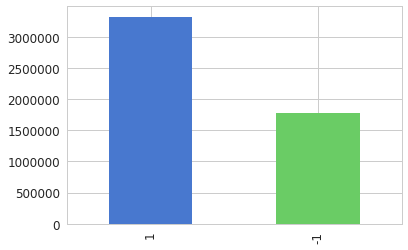

In [5]:
AYE = 1
NAY = -1
vote_map = {'Yea': AYE,'Nay': NAY}

def map_vote(row):
    print(row)
    return vote_map[row['vote']]

df_final['vote'] = df_final['vote'].apply(lambda x: vote_map[x])
# df_final['vote'] = df_final.vote.apply(map_vote)
print(df_final['vote'].value_counts())
df_final['vote'].value_counts().plot(kind='bar')

In [6]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('/home/sonic/.keras/datasets/GoogleNews-vectors-negative300.bin',
                                                        binary=True)


In [7]:

replace_puncts = {'`': "'", '′': "'", '“':'"', '”': '"', '‘': "'"}

strip_chars = [',', '.', '"', ':', ')', '(', '-', '|', ';', "'", '[', ']', '>', '=', '+', '\\', '•',  '~', '@', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█',
 '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦',
 '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', 
 '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', 
 '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']

puncts = ['!', '?', '$', '&', '/', '%', '#', '*','£']

def clean_str(x):
    x = str(x)
    
    x = x.lower()
    
    x = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})", "url", x)
    
    for k, v in replace_puncts.items():
        x = x.replace(k, " {v} ")
        
    for punct in strip_chars:
        x = x.replace(punct, ' ') 
    
    for punct in puncts:
        x = x.replace(punct, ' {punct} ')
        
    x = x.replace(" '", " ")
    x = x.replace("' ", " ")
        
    return x


df_bills['billText_clean'] = df_bills['billText'].apply(clean_str)

In [8]:
print(clean_str('u.s \'very" has trump!'))

u s  very  has trump {punct} 


In [9]:
df_bills['l'] = df_bills['billText_clean'].apply(lambda x: len(str(x).split(' ')))
print('text stats')
# df_bills['l'].plot.hist(bins=5, alpha=0.5)
df_bills['l'].describe()

text stats


count      4062.000000
mean       3964.086411
std       12035.121352
min           1.000000
25%         256.250000
50%         572.000000
75%        1821.750000
max      120490.000000
Name: l, dtype: float64

In [10]:
%%time

max_words = 20000
MAX_SEQUENCE_LENGTH = 1000
def process_doc(X):
    
    tokenizer = Tokenizer(num_words=max_words,lower=True, split=' ', 
                          filters='"#%&()*+-/<=>@[\\]^_`{|}~\t\n',
                          char_level=False, oov_token=u'<UNK>')

    X_text = X['billText_clean'].values
    tokenizer.fit_on_texts(X_text)
    print(X.shape)
    
    X_seq = np.array(tokenizer.texts_to_sequences(X_text))
    X_seq = pad_sequences(X_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    print('X_seq', X_seq.shape)

    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(X_text)

    tf_transformer = TfidfTransformer().fit(X_train_counts)
    X_train_tf = tf_transformer.transform(X_train_counts)

    x_emb = {}
    #     tokens = nltk.word_tokenize(list(X))
#     print('tokens.shape', tokens.shape)

    for idx, doc in tqdm(X.iterrows()): #look up each doc in model
#         print(doc['legis_num'], doc['billText'])
        x_emb[doc['legis_num']] = document_vector(word2vec_model, nltk.word_tokenize(doc['billText_clean'].lower()))
    
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))


    return np.array(X_seq), word_index, x_emb, X_train_tf, X_train_counts

def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in word2vec_model.vocab]
    return np.mean(word2vec_model[doc], axis=0)


def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)


df_bills['billText_clean'] = df_bills['billText_clean'].apply(str)
X_seq, word_index, X_emb, X_train_tf, X_train_counts = process_doc(df_bills)
# df_bills['X_seq'] = X_seq
# df_bills['X_emb'] = X_emb
# df_bills['X_train_tf'] = X_train_tf
# df_bills['X_train_counts'] = X_train_counts

# print(X_emb.shape)
print(X_emb['H R 5010'].shape)

(4062, 32)
X_seq (4062, 1000)


4062it [01:19, 51.38it/s]

Found 54488 unique tokens.
(300,)
CPU times: user 1min 33s, sys: 636 ms, total: 1min 33s
Wall time: 1min 33s


In [11]:
from keras.initializers import glorot_uniform  # Or your initializer of choice
from tqdm import tqdm

def plot_history(history):
#     print(history.history)
    df = pd.DataFrame(history.history)
    print(df.describe())
    df.plot(xticks=range(epochs))
#     print(history.history.keys())


def extract_weights(name, model):
    """Extract weights from a neural network model"""
    
    # Extract weights
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    
    # Normalize
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights


def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
            

    
def getDataset(df):
    dataset = df[['name', 'legis_num', 
                  'vote', 'party',
                  'sponsor_party', 'sponsor_state', 
                  'sponsor_id']]
#     print(df.columns)
    dataset['bill_id'] = dataset.legis_num.astype('category').cat.codes.values
    dataset['name_id'] = dataset.name.astype('category').cat.codes.values
    dataset['vote_orig'] = dataset['vote']
#     dataset['vote'] = dataset.vote.astype('category').cat.codes.values
#     dataset['vote'] = dataset.vote.apply(map_vote)

    dataset['sponsor_party'] = dataset.sponsor_party.astype('category').cat.codes.values
    dataset['sponsor_id'] = dataset.sponsor_id.astype('category').cat.codes.values
    dataset['sponsor_state'] = dataset.sponsor_state.astype('category').cat.codes.values
    # dataset.drop(columns=['name', 'legis_num'], inplace=True)
    dataset = dataset.sample(frac=0.9, replace=True)
    dataset.reset_index(inplace=True)
    return dataset

In [12]:
df_embeding = pd.DataFrame(X_emb)
df_embeding.tail()

,ADJOURN,H CON RES 100,H CON RES 102,H CON RES 103,H CON RES 104,H CON RES 105,H CON RES 109,H CON RES 110,H CON RES 111,H CON RES 112,...,S J RES 19,S J RES 22,S J RES 23,S J RES 24,S J RES 28,S J RES 32,S J RES 34,S J RES 45,S J RES 6,S J RES 8
295,-0.108398,-0.003415,-0.010622,0.013526,-0.023374,0.048985,0.036316,0.011766,-0.020291,-0.018430,...,0.024564,-0.009911,-0.014684,-0.132002,-0.028477,0.009978,-0.049826,-0.001484,-0.005950,0.006288
296,-0.345703,-0.056840,0.003421,-0.057596,-0.063582,-0.006448,-0.008928,-0.025768,-0.025604,-0.023880,...,-0.019163,-0.010501,-0.010352,-0.067296,0.008832,-0.046741,-0.045225,-0.016162,-0.044327,-0.008809
297,-0.134766,-0.028996,-0.039948,-0.015749,-0.037200,-0.048065,-0.049017,-0.060376,-0.050861,-0.049559,...,-0.071843,-0.060956,-0.030253,-0.112047,-0.065230,-0.055063,-0.067000,-0.038568,-0.100078,-0.052419
298,-0.052979,0.023531,0.036924,0.067903,-0.003091,-0.002703,-0.004516,-0.014047,-0.010697,0.027422,...,-0.029320,-0.008824,0.005135,-0.010401,0.000554,0.000409,0.019830,0.036972,-0.025607,-0.003320
299,0.103516,0.022112,-0.003504,0.037394,0.010055,-0.020468,-0.000530,0.022217,-0.034027,0.022516,...,-0.013715,-0.017386,0.007810,0.038290,0.029844,0.015322,0.040106,0.007634,-0.022000,0.003208


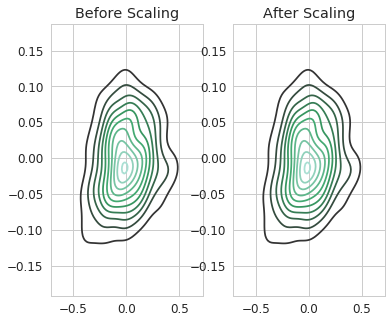

,ADJOURN,H CON RES 100,H CON RES 102,H CON RES 103,H CON RES 104,H CON RES 105,H CON RES 109,H CON RES 110,H CON RES 111,H CON RES 112,...,S J RES 19,S J RES 22,S J RES 23,S J RES 24,S J RES 28,S J RES 32,S J RES 34,S J RES 45,S J RES 6,S J RES 8
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,...,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,-0.007275,-0.003924,-0.003417,-0.004551,-0.002826,-0.003119,-0.003276,0.001088,-0.001237,-0.004714,...,-0.002379,-0.004134,-0.002839,-0.002757,-0.004864,-0.004908,-0.001158,-0.004960,-0.001635,-0.004222
std,0.188810,0.052116,0.051351,0.055680,0.051765,0.052360,0.052777,0.053050,0.053420,0.051846,...,0.058028,0.049246,0.050432,0.076854,0.052552,0.055011,0.056927,0.049776,0.060536,0.049614
min,-0.494141,-0.131831,-0.126352,-0.148662,-0.119872,-0.158712,-0.158876,-0.142134,-0.160710,-0.142261,...,-0.141606,-0.146958,-0.152885,-0.192442,-0.159249,-0.169197,-0.137778,-0.146454,-0.147399,-0.149972
25%,-0.129150,-0.041299,-0.040154,-0.042572,-0.038052,-0.040018,-0.039727,-0.031982,-0.041117,-0.036959,...,-0.036880,-0.035910,-0.035971,-0.055821,-0.041042,-0.040689,-0.042349,-0.038263,-0.040913,-0.037092
50%,-0.009186,-0.004966,-0.005179,-0.001546,-0.007761,-0.006339,-0.006520,0.000143,-0.000424,-0.004250,...,-0.001991,-0.004256,-0.004574,-0.001623,-0.005896,-0.003658,-0.001829,-0.006418,-0.005841,-0.003510
75%,0.122070,0.032787,0.031588,0.030743,0.036068,0.029360,0.030819,0.036722,0.036544,0.028997,...,0.034697,0.031433,0.029798,0.050619,0.027755,0.034796,0.038404,0.029487,0.040740,0.026885
max,0.503906,0.126606,0.159841,0.141276,0.132620,0.139918,0.150113,0.165856,0.150604,0.168122,...,0.151202,0.139124,0.142694,0.187374,0.174491,0.134597,0.157293,0.132350,0.169228,0.141203


In [13]:

scaler = preprocessing.MinMaxScaler( feature_range=(0, 1))
# df_embeding_scaled = scaler.fit_transform(df_embeding)
# DONT normalize
df_embeding_scaled = df_embeding
df_embeding_scaled = pd.DataFrame(df_embeding_scaled, columns=df_embeding.columns)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 5))

ax1.set_title('Before Scaling')
sns.kdeplot(df_embeding, ax=ax1)

ax2.set_title('After Scaling')
sns.kdeplot(df_embeding_scaled, ax=ax2)

plt.show()
df_embeding_scaled.describe()

In [14]:
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Input, UpSampling2D


# df_final[df_final['name'] == 'Bateman']




In [15]:
# df_votes_filtered = df_final[df_final['congress'] == 106]
# bill_text = df_embeding_scaled[list(df_votes_filtered['legis_num'].unique())]
# # bill_text.T
# bill_text = np.array(bill_text.T)
# bill_text[1].shape
# df_votes_filtered['legis_num'].unique()
df_final.drop(columns=['Unnamed: 0', 'level_0', 'index', 'Unnamed: 0.1'], inplace=True)
df_final.tail()

,action_date,action_time,chamber,congress,legis_num,majority,name,party,role,rollcall_num,...,vote,vote_desc,vote_question,vote_result,vote_type,sponsor,sponsor_id,sponsor_party,sponsor_state,sponsor_uri
5103690,19-Mar-2015,12:08 PM,U.S. House of Representatives,114,S J RES 8,R,Yoho,R,legislator,128,...,1,Providing for congressional disapproval under ...,On Passage,Passed,YEA-AND-NAY,Lamar Alexander,A000360,R,TN,https://api.propublica.org/congress/v1/members...
5103691,19-Mar-2015,12:08 PM,U.S. House of Representatives,114,S J RES 8,R,Young (AK),R,legislator,128,...,1,Providing for congressional disapproval under ...,On Passage,Passed,YEA-AND-NAY,Lamar Alexander,A000360,R,TN,https://api.propublica.org/congress/v1/members...
5103692,19-Mar-2015,12:08 PM,U.S. House of Representatives,114,S J RES 8,R,Young (IA),R,legislator,128,...,1,Providing for congressional disapproval under ...,On Passage,Passed,YEA-AND-NAY,Lamar Alexander,A000360,R,TN,https://api.propublica.org/congress/v1/members...
5103693,19-Mar-2015,12:08 PM,U.S. House of Representatives,114,S J RES 8,R,Zeldin,R,legislator,128,...,1,Providing for congressional disapproval under ...,On Passage,Passed,YEA-AND-NAY,Lamar Alexander,A000360,R,TN,https://api.propublica.org/congress/v1/members...
5103694,19-Mar-2015,12:08 PM,U.S. House of Representatives,114,S J RES 8,R,Zinke,R,legislator,128,...,1,Providing for congressional disapproval under ...,On Passage,Passed,YEA-AND-NAY,Lamar Alexander,A000360,R,TN,https://api.propublica.org/congress/v1/members...


In [16]:
df_final = df_final.sort_values('action_date').drop_duplicates(['legis_num','name'], keep='last')
df_final.reset_index(inplace=True)
df_final.tail()

,index,action_date,action_time,chamber,congress,legis_num,majority,name,party,role,...,vote,vote_desc,vote_question,vote_result,vote_type,sponsor,sponsor_id,sponsor_party,sponsor_state,sponsor_uri
1948296,3086352,9-Sep-2016,12:03 PM,U.S. House of Representatives,114,H R 5424,R,Yoder,R,legislator,...,-1,Investment Advisers Modernization Act of 2016,On Motion to Recommit with Instructions,Failed,YEA-AND-NAY,Robert Hurt,H001060,R,VA,https://api.propublica.org/congress/v1/members...
1948297,3086351,9-Sep-2016,12:03 PM,U.S. House of Representatives,114,H R 5424,R,Yarmuth,D,legislator,...,1,Investment Advisers Modernization Act of 2016,On Motion to Recommit with Instructions,Failed,YEA-AND-NAY,Robert Hurt,H001060,R,VA,https://api.propublica.org/congress/v1/members...
1948298,3086350,9-Sep-2016,12:03 PM,U.S. House of Representatives,114,H R 5424,R,Woodall,R,legislator,...,-1,Investment Advisers Modernization Act of 2016,On Motion to Recommit with Instructions,Failed,YEA-AND-NAY,Robert Hurt,H001060,R,VA,https://api.propublica.org/congress/v1/members...
1948299,3086358,9-Sep-2016,12:09 PM,U.S. House of Representatives,114,H R 5424,R,Abraham,R,legislator,...,1,Investment Advisers Modernization Act of 2016,On Passage,Passed,YEA-AND-NAY,Robert Hurt,H001060,R,VA,https://api.propublica.org/congress/v1/members...
1948300,3086354,9-Sep-2016,12:03 PM,U.S. House of Representatives,114,H R 5424,R,Young (AK),R,legislator,...,-1,Investment Advisers Modernization Act of 2016,On Motion to Recommit with Instructions,Failed,YEA-AND-NAY,Robert Hurt,H001060,R,VA,https://api.propublica.org/congress/v1/members...


In [28]:

from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics

# Working 
def denoiser_autoencoder(text_all, meta_all, label_all):
    print('text_all.shape', text_all.shape)
    print('meta_all.shape', meta_all.shape)
    
    input_img = Input(shape=(text_all.shape[1], text_all.shape[2]))
    encoded = Dense(256, activation='relu', kernel_initializer='glorot_uniform')(input_img)
    encoded = BatchNormalization()(encoded)
    encoded = Dense(128, activation='relu')(encoded)
    encoded = Dense(64, activation='relu',  name='encoded')(encoded)

    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(text_all.shape[2], activation='sigmoid')(decoded)
    autoencoder = Model(input_img, decoded)
    loss = 'mean_squared_error'
#     loss='binary_crossentropy'
    autoencoder.compile(optimizer='RMSprop', loss=loss, metrics=['accuracy', 'binary_crossentropy'])
    autoencoder.summary()
    
    encoder = Model(inputs=input_img, outputs= autoencoder.get_layer('encoded').output)
    
    # train
    history = autoencoder.fit(meta_all, text_all, epochs=epochs, 
                              batch_size=256, shuffle=True, verbose=1)
    plot_history(history)
    
    
    return autoencoder, encoder  

def deep_AE(text_all, meta_all):
    print('text_all.shape', text_all.shape)
    print('meta_all.shape', meta_all.shape)
    input_i = Input(shape=(text_all.shape[1], text_all.shape[2]))
    encoded_h1 = Dense(64, activation='tanh')(input_i)
    encoded_h2 = Dense(32, activation='tanh')(encoded_h1)
    encoded_h3 = Dense(16, activation='tanh')(encoded_h2)
    encoded_h4 = Dense(8, activation='tanh')(encoded_h3)
    encoded_h5 = Dense(4, activation='tanh')(encoded_h4)
    latent = Dense(2, activation='tanh', name='encoded')(encoded_h5)
    decoder_h1 = Dense(4, activation='tanh')(latent)
    decoder_h2 = Dense(8, activation='tanh')(decoder_h1)
    decoder_h3 = Dense(16, activation='tanh')(decoder_h2)
    decoder_h4 = Dense(32, activation='tanh')(decoder_h3)
    decoder_h5 = Dense(64, activation='tanh')(decoder_h4)
    output = Dense(text_all.shape[2], activation='tanh')(decoder_h5)
    autoencoder = Model(input_i,output)
    autoencoder.compile(optimizer='adadelta', loss='mse')
    autoencoder.summary()
    encoder = Model(inputs=input_i, outputs= autoencoder.get_layer('encoded').output)
    # train
    history = autoencoder.fit(meta_all, text_all, epochs=epochs, 
                              batch_size=256, shuffle=True, verbose=1)
    plot_history(history)    
    return autoencoder, encoder  


 
# https://github.com/snatch59/keras-autoencoders/blob/master/variational_autoencoder.py
def VAE(text_all, meta_all, label_all):
    original_dim = text_all.shape[1] * text_all.shape[2]
    text_all = np.reshape(text_all, [-1, original_dim])
    meta_all = np.reshape(meta_all, [-1, original_dim])
    print('text_all.shape', text_all.shape)
    print('meta_all.shape', meta_all.shape)
    batch_size = 100
    
    latent_dim = 2
    intermediate_dim = 256
    epsilon_std = 1.0

    x = Input(shape=(original_dim,))
#     x = Input(shape=(text_all.shape[1], text_all.shape[2]))
    h = Dense(intermediate_dim, activation='relu')(x)
    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)


    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon


    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # we instantiate these layers separately so as to reuse them later
    decoder_h = Dense(intermediate_dim, activation='relu')
    decoder_mean = Dense(original_dim, activation='sigmoid')
    h_decoded = decoder_h(z)
    x_decoded_mean = decoder_mean(h_decoded)

    # instantiate VAE model
    vae = Model(x, x_decoded_mean)

    # Compute VAE loss
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)

    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop', metrics=['accuracy', 'mse'])
    print(vae.summary())


    history = vae.fit(meta_all, shuffle=True, epochs=epochs, batch_size=batch_size, verbose=1)
    plot_history(history)

    # build a model to project inputs on the latent space
    encoder = Model(x, z_mean)
    return vae, encoder

Processing congress 106
congress shape (110014, 23)
number of legistlators 435
number of bills 313


  2%|▏         | 8/435 [00:00<00:05, 75.26it/s]

train.shape (79210, 11)
test.shape (19803, 11)
running embedding mode


100%|██████████| 435/435 [00:05<00:00, 74.19it/s]


text_all.shape (435, 313, 300)
meta_all.shape (435, 313, 300)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 313, 300)          0         
_________________________________________________________________
dense_49 (Dense)             (None, 313, 256)          77056     
_________________________________________________________________
batch_normalization_4 (Batch (None, 313, 256)          1024      
_________________________________________________________________
dense_50 (Dense)             (None, 313, 128)          32896     
_________________________________________________________________
encoded (Dense)              (None, 313, 64)           8256      
_________________________________________________________________
dense_51 (Dense)             (None, 313, 64)           4160      
_________________________________________________________________
dense_52 (Dens

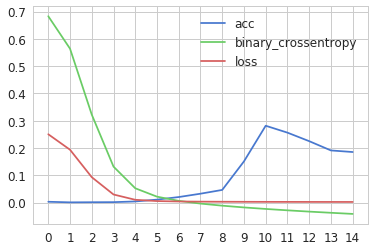

In [64]:
noise_factor = 0.5

#EPOCHS
epochs = 15

scaler = preprocessing.MinMaxScaler( feature_range=(0, 1))

pred_all = {}
cp_party_all = {}

def runDenoiserAE(df_final):
    congress_info = {}
    grouped_congress = df_final.groupby('congress')
    for congress_session, group in grouped_congress:
        print('Processing congress', congress_session)
        print('congress shape', group.shape)
        cp_party = {}

        df_votes_filtered = df_final[df_final['congress'] == congress_session]
        num_legistlators = len(df_votes_filtered['name'].unique())
        num_bills = len(df_votes_filtered['legis_num'].unique())
        print('number of legistlators', num_legistlators)
        print('number of bills', num_bills)

        dataset = getDataset(df_votes_filtered)
        train, test = train_test_split(dataset, test_size=0.2)
        print('train.shape', train.shape)
        print('test.shape', test.shape)
        congress_info[congress_session] = {'num_legislators': num_legistlators, 
                               'num_bills' : num_bills, 
                               'dataset.shape' : dataset.shape[0], 
                               'train.shape': train.shape[0], 
                               'test.shape': test.shape[0]}
        
        # get bill text for the session, this is shared for all CP
        bill_text = df_embeding_scaled[list(df_votes_filtered['legis_num'].unique())]
        bill_text = np.array(bill_text.T)
        
        print("running embedding mode")
        text_all = []
        meta_all = []
        label_all = []
        for name, cp_group in tqdm(train.groupby(['name_id'])): 
            cp_group.reset_index(inplace=True)
#             print(cp_group.shape)
#             print(name, cp_group.iloc[0]['name'])

            labels = np.random.normal(loc=0.0, scale=1.0, size=num_bills)
#             print(labels)
            
            for ind, vote in cp_group.iterrows():
                labels[ind] = float(vote['vote'])

#             print(labels)
            meta = np.multiply(bill_text, np.vstack(labels)) # Eelementwise multiplication, introducing noise
            meta = meta + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=meta.shape)
#             meta = scaler.fit_transform(meta)
#             meta = np.clip(meta, 0., 1.)
#             print('bill_text.shape', bill_text.shape)
#             print('meta.shape', meta.shape)
#             print('labels.shape', labels.shape)
#             print(bill_text[0])
#             print('**********************')
#             print(meta[0])
#             plot_emd_meta(bill_text, meta, cp_group.iloc[0]['name'])
            text_all.append(bill_text)
            meta_all.append(meta)
            label_all.append(labels)
            
            # create CP dict
            cp_party[cp_group.iloc[0]['name']] = cp_group['party'].unique()[0]
#             break
        
        cp_party_all[congress_session] = cp_party
        
        ################# VAE ##########################
        text_all = np.array(text_all)
        original_dim = text_all.shape[1] * text_all.shape[2]
#         autoencoder, encoder = VAE(np.asarray(text_all), np.asarray(meta_all), np.asarray(label_all))
#         encoded_weights = encoder.predict(np.reshape(text_all, [-1, original_dim]))
        #####################################################
#         autoencoder, encoder = deep_AE(np.asarray(text_all), np.asarray(meta_all),)
        ################# DENOISER ##########################      
        autoencoder, encoder = denoiser_autoencoder(np.asarray(text_all), np.asarray(meta_all), np.asarray(label_all))
        encoded_weights = encoder.predict(np.asarray(meta_all))  
        ###########################################
        pred_all[congress_session] = encoded_weights
        print('encoded_weights.shape', encoded_weights.shape)
        print('pred[congress_session].shape', pred_all[congress_session].shape)
        
        break
        
    return congress_info
    
    
def plot_emd_meta(embeding, embeding_meta, cp_name):  
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(6, 5))
    ax1.set_title('embedding')
    ax1.plot(embeding)
    ax2.set_title('meta')
    ax2.plot(embeding_meta)
    plt.savefig('../data/cp_name/%s.png' % cp_name)

congress_info = runDenoiserAE(df_final)
print(congress_info)    

(435, 20032)
activations.shape (435, 20032)
['D' 'I' 'R']
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 435 samples in 0.102s...
[t-SNE] Computed neighbors for 435 samples in 3.716s...
[t-SNE] Computed conditional probabilities for sample 435 / 435
[t-SNE] Mean sigma: 19.152540
[t-SNE] Computed conditional probabilities in 0.139s
[t-SNE] Iteration 50: error = 85.4892273, gradient norm = 0.4391607 (50 iterations in 0.214s)
[t-SNE] Iteration 100: error = 87.1511993, gradient norm = 0.4866464 (50 iterations in 0.279s)
[t-SNE] Iteration 150: error = 90.4066086, gradient norm = 0.4180444 (50 iterations in 0.264s)
[t-SNE] Iteration 200: error = 88.3374863, gradient norm = 0.4484311 (50 iterations in 0.259s)
[t-SNE] Iteration 250: error = 86.1807327, gradient norm = 0.4711553 (50 iterations in 0.235s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.180733
[t-SNE] Iteration 300: error = 2.3467426, gradient norm = 0.0047092 (50 iterations in 0.213s)
[t-SNE] It

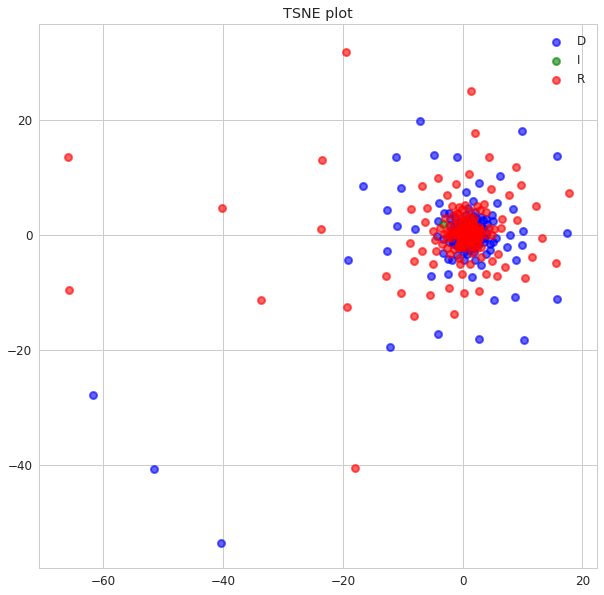

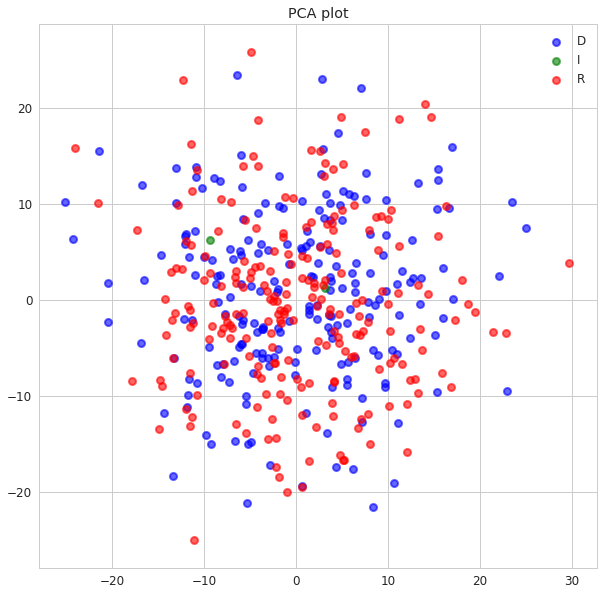

In [70]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib


def plot_TNSE_meta(activations, cp_party):
    activations =  activations.reshape((activations.shape[0], -1))
    print(activations.shape)
#     transformer = QuantileTransformer(n_quantiles=10, random_state=0)
#     transformer = PowerTransformer(method='yeo-johnson')
#     activations = transformer.fit_transform(activations) 

    print('activations.shape', activations.shape)
    le = preprocessing.LabelEncoder()
    colors = [ 'b','g', 'r']
    y = []
    
#     print(cp_party)
    for key, value in cp_party.items():
        y.append(value)
        
#     print(y)
    le.fit(y)
    print(le.classes_)
    y = le.transform(y)
#     print(y)
    
    X_tsne = TSNE(n_components=2, verbose=2).fit_transform(activations)
    plt.figure(figsize=(10, 10),)
    for color, i, target_name in zip(colors, [0, 1, 2], le.classes_):
        plt.scatter(X_tsne[y == i, 0], X_tsne[y == i, 1], cmap=matplotlib.colors.ListedColormap(colors),
                    color=color, alpha=.6, lw=2, label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('TSNE plot')
    plt.show()

    # PCA
    X_pca = PCA(n_components=2).fit_transform(activations)
    plt.figure(figsize=(10, 10),)
    for color, i, target_name in zip(colors, [0, 1, 2], le.classes_):
        plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], cmap=matplotlib.colors.ListedColormap(colors),
                    color=color, alpha=.6, lw=2, label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('PCA plot')
    plt.show()
    ########################################################################
    
plot_TNSE_meta(pred_all[106], cp_party_all[106])

In [66]:
# pred_all[106]
# print(cp_party_all[106])
print(pred_all[106].shape)
activations =  pred_all[106].reshape((pred_all[106].shape[0], -1))
print(activations.shape)

(435, 313, 64)
(435, 20032)


(435, 20032)


,0,1,2,3,4,5,6,7,8,9,...,20022,20023,20024,20025,20026,20027,20028,20029,20030,20031
430,0.099325,0.440291,0.460700,-1.138230,-0.695095,-0.692051,-0.808270,-0.641851,0.385473,-0.111115,...,-0.742027,-0.477437,-0.238324,0.160044,-0.639165,-0.10634,-1.242358,1.147883,1.210599,-0.576748
431,1.815653,-1.451376,1.263521,-0.423800,-1.641257,0.266224,-1.250289,-1.013600,1.396014,-0.111115,...,0.549009,0.116268,-0.750846,3.193626,-0.543411,-0.10634,1.418399,-0.341296,4.900903,1.683528
432,-0.055013,0.129810,0.508319,0.700571,0.432304,-0.692051,0.562679,-0.580474,0.900328,-0.111115,...,0.148560,-0.477437,-0.692548,-0.885321,-0.343123,-0.10634,-1.242358,-0.400154,-0.436459,-0.054047
433,-0.561569,-1.028832,-1.929960,0.713131,-0.626061,-0.692051,1.740965,2.688679,1.048190,-0.111115,...,-1.916072,-0.292553,0.129945,0.035762,-0.691427,-0.10634,-1.242358,-1.492065,2.167993,0.952858
434,0.610565,-1.451376,-0.743827,-0.630824,-0.196084,-0.692051,0.448265,-0.483644,-0.544489,-0.111115,...,0.759557,2.594360,1.045794,1.245786,-1.725305,-0.10634,0.699253,0.471395,0.639522,0.277900


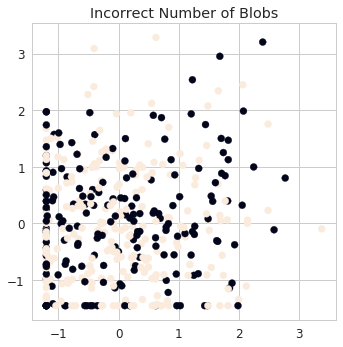

In [69]:
from sklearn.preprocessing import StandardScaler
from sklearn import cluster

activations = pred_all[106]
activations =  activations.reshape((activations.shape[0], -1))

plt.figure(figsize=(12, 12))

from sklearn.cluster import KMeans
# normalize dataset for easier parameter selection
activations = StandardScaler().fit_transform(activations)

# Incorrect number of clusters
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(activations)

plt.subplot(221)
plt.scatter(activations[:, 0], activations[:, 1], c=y_pred)
plt.title("Incorrect Number of Blobs")
plt.show


print(activations.shape)
df = pd.DataFrame(activations)
df.tail()